In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# First Look @ Measurement

m_firstrow = session.query(Measurement).first()
m_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21117cb3fc8>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [11]:
# First Look @ Station

s_firstrow = session.query(Station).first()
s_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21117ccdc88>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0}

In [12]:
# Importing module and getting data types for measurement
from sqlalchemy import inspect

inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# .. and station

inspector = inspect(engine)
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# --Design a query to retrieve the last 12 months of precipitation data and plot the results

# getting date info including year from last date

print('earliest day')
print(session.query(Measurement.date).order_by(Measurement.date).first())
print('latest day')
print(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
print('total dates')
print(session.query(func.count(Measurement.date)).all())

#latest_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#latest_day = list(np.ravel(latest_day))[0]
#year_before = 

earliest day
('2010-01-01',)
latest day
('2017-08-23',)
total dates
[(19550,)]


In [15]:
# ... creating query to retrieve the data and precipitation scores over the last year from the latest date

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date.desc()).all()

prcp_data = []

for row in results:
    print(row)
    prcp_data.append(row)


('2017-08-23', 0.0)
('2017-08-23', 0.0)
('2017-08-23', 0.08)
('2017-08-23', 0.45)
('2017-08-22', 0.0)
('2017-08-22', 0.0)
('2017-08-22', 0.5)
('2017-08-21', 0.0)
('2017-08-21', 0.02)
('2017-08-21', None)
('2017-08-21', 0.56)
('2017-08-20', 0.0)
('2017-08-20', 0.01)
('2017-08-20', None)
('2017-08-19', 0.0)
('2017-08-19', 0.0)
('2017-08-19', None)
('2017-08-19', 0.09)
('2017-08-18', 0.0)
('2017-08-18', 0.0)
('2017-08-18', 0.06)
('2017-08-18', None)
('2017-08-17', 0.0)
('2017-08-17', 0.05)
('2017-08-17', 0.01)
('2017-08-17', 0.13)
('2017-08-16', 0.0)
('2017-08-16', 0.07)
('2017-08-16', 0.12)
('2017-08-16', 0.42)
('2017-08-15', 0.02)
('2017-08-15', 0.0)
('2017-08-15', 0.06)
('2017-08-15', 0.32)
('2017-08-15', 0.42)
('2017-08-14', 0.0)
('2017-08-14', 0.01)
('2017-08-14', 0.08)
('2017-08-14', 0.0)
('2017-08-14', 0.22)
('2017-08-13', 0.0)
('2017-08-13', None)
('2017-08-13', 0.0)
('2017-08-13', 0.0)
('2017-08-13', None)
('2017-08-12', 0.0)
('2017-08-12', 0.0)
('2017-08-12', 0.14)
('2017-08-11'

('2016-11-22', None)
('2016-11-22', None)
('2016-11-22', 0.31)
('2016-11-22', 2.05)
('2016-11-22', 2.11)
('2016-11-21', 0.01)
('2016-11-21', 0.02)
('2016-11-21', None)
('2016-11-21', 0.07)
('2016-11-21', 0.11)
('2016-11-21', 2.87)
('2016-11-20', 0.05)
('2016-11-20', 0.11)
('2016-11-20', 0.4)
('2016-11-20', 0.39)
('2016-11-20', None)
('2016-11-19', 0.03)
('2016-11-19', 0.11)
('2016-11-19', 0.13)
('2016-11-19', 0.11)
('2016-11-18', 0.0)
('2016-11-18', 0.01)
('2016-11-18', None)
('2016-11-18', 0.02)
('2016-11-18', 0.0)
('2016-11-17', 0.0)
('2016-11-17', 0.03)
('2016-11-17', 0.0)
('2016-11-17', None)
('2016-11-17', 0.0)
('2016-11-17', 0.01)
('2016-11-17', 0.02)
('2016-11-16', 0.0)
('2016-11-16', 0.14)
('2016-11-16', 0.18)
('2016-11-16', None)
('2016-11-16', 0.07)
('2016-11-16', 0.24)
('2016-11-16', 0.91)
('2016-11-15', 0.0)
('2016-11-15', 0.0)
('2016-11-15', 0.0)
('2016-11-15', None)
('2016-11-15', 0.0)
('2016-11-15', 0.0)
('2016-11-15', 0.05)
('2016-11-14', 0.0)
('2016-11-14', 0.06)
('201

In [16]:
print(len(prcp_data))

#dates = [result[0] for result in results[:1397]]
#prcp = [result[1] for result in results[:1397]]
#x = df.groupby(['Date']).mean()
#x.plot.bar()

# ...making DF
df = pd.DataFrame(prcp_data, columns=['Date', 'Prcp'])

# ...changing string object to datetime object  
df['Date']= pd.to_datetime(df['Date'])

# ...sorting
df = df.sort_values(['Date'], ascending=True)

# ...& setting the index to the date column
df = df.set_index('Date')

# dropping null Prcp rows
df = df.dropna()

df

2223


,Prcp
Date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,2.28
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


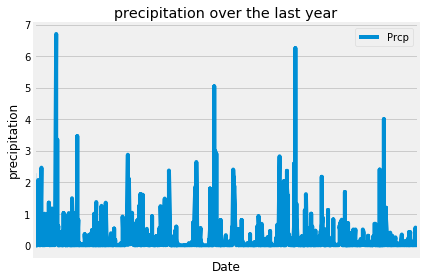

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line()
plt.xticks([])
plt.title('precipitation over the last year')
plt.ylabel('precipitation')
plt.tight_layout()
plt.show()

In [18]:
# ...summary statistics for the precipitation data
df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
# ...get total num of stations in data set
stations = session.query(Measurement.station).all()

station_list = []

for station in stations:
    if station not in station_list:
        station_list.append(station)
        print(station)

print('____________________')
print(f'There are {len(station_list)} stations represented in the data set.')

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)
____________________
There are 9 stations represented in the data set


In [35]:
# ...list the stations & obsv counts in descending order

station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# ...show the most active station

most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

print(f'The most active station is {most_active_station[0]} with {most_active_station[1]} rows of data.')

The most active station is USC00519281 with 2772 rows of data.


In [64]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

MAS = most_active_station[0]
MAS

highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == MAS).all()
    
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == MAS).all()

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == MAS).all()

print(highest_temp)
print(lowest_temp)
print(avg_temp)

[('USC00519281', 85.0)]
[('USC00519281', 54.0)]
[('USC00519281', 71.66378066378067)]


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
